In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import contextlib
from ler.rates import LeR
from gwsnr import GWSNR
from ler.utils import append_json, get_param_from_json

Setting multiprocessing start method to 'fork'


In [ ]:
class TrainingDataGenerator():

    def __init__(self,
        npool=4,
        z_min=0.0,
        z_max=5.0,
        verbose=True,
        output_jsonfile="L1H1V1_IMRPhenomXPHM.json",
        **kwargs,  # ler and gwsnr arguments
    ):

        self.npool = npool
        self.z_min = z_min
        self.z_max = z_max
        self.verbose = verbose

        self.ler_init_args = dict(
            event_type="BBH",
            cosmology=None,
            ler_directory="./ler_data",
            spin_zero=False,
            spin_precession=True,
            # gwsnr args
            mtot_min=2.0,
            mtot_max=200,
            ratio_min=0.1,
            ratio_max=1.0,
            mtot_resolution=500,
            ratio_resolution=50,
            sampling_frequency=2048.0,
            waveform_approximant="IMRPhenomXPHM",
            minimum_frequency=20.0,
            snr_type="inner_product",
            psds=None,
            ifos=None,
            interpolator_dir="./interpolator_pickle",
            create_new_interpolator=False,
            gwsnr_verbose=False,
            multiprocessing_verbose=True,
            mtot_cut=True,
        )
        self.ler_init_args.update(kwargs)

        self.json_path = f"{self.ler_init_gwsnr_args['ler_directory']}/{output_jsonfile}"

        # recalculate snr within the snr_range.
        # find snr in astrophysical range
        # save it

    def gw_parameters_generator(self, size, batch_size, snr_recalculation=True,trim_to_size=False, verbose=True, replace=False, data_distribution_range = [0, 2, 4, 6, 8, 10, 12, 14, 16, 100]):

        args = self.ler_init_args.copy()
        if snr_recalculation:
            snr_type = 'interpolation'
        else:
            snr_type = 'inner_product'

        # ler initialization
        ler = LeR(
            npool=self.npool,
            z_min=self.z_min,
            z_max=self.z_max,  # becareful with this value
            verbose=self.verbose,
            # ler
            event_type=self.gwsnr_args['event_type'],
            cosmology=self.gwsnr_args['cosmology'],
            ler_directory=self.gwsnr_args['ler_directory'],
            spin_zero=self.gwsnr_args['spin_zero'],
            spin_precession=self.gwsnr_args['spin_precession'],
            # gwsnr args
            mtot_min=self.gwsnr_args['mtot_min'],
            mtot_max=self.gwsnr_args['mtot_max'],
            ratio_min=self.gwsnr_args['ratio_min'],
            ratio_max=self.gwsnr_args['ratio_max'],
            mtot_resolution=self.gwsnr_args['mtot_resolution'],
            ratio_resolution=self.gwsnr_args['ratio_resolution'],
            sampling_frequency=self.gwsnr_args['sampling_frequency'],
            waveform_approximant=self.gwsnr_args['waveform_approximant'],
            minimum_frequency=self.gwsnr_args['minimum_frequency'],
            snr_type=snr_type,
            psds=self.gwsnr_args['psds'],
            ifos=self.gwsnr_args['ifos'],
            interpolator_dir=self.gwsnr_args['interpolator_dir'],
            create_new_interpolator=self.gwsnr_args['create_new_interpolator'],
            gwsnr_verbose=self.gwsnr_args['gwsnr_verbose'],
            multiprocessing_verbose=self.gwsnr_args['multiprocessing_verbose'],
            mtot_cut=self.gwsnr_args['mtot_cut'],
        )
        ler.batch_size = batch_size

        # path to save parameters
        json_path = self.json_path
        if replace:
            if os.path.exists(json_path):
                os.remove(json_path)
            len_final = 0
        else:
            unlensed_param = get_param_from_json(json_path)
            len_final = len(unlensed_param['optimal_snr_net'])
            print(f'current size of the json file: {len_final}\n')

        print(f'total event to collect: {size}\n')
        while len_final<size:
            with contextlib.redirect_stdout(None):
                unlensed_param = ler.unlensed_cbc_statistics(size=ler.batch_size, resume=False)

            if data_distribution_range is not None:
                unlensed_param = self.helper_data_distribution(unlensed_param, data_distribution_range)

                if snr_recalculation:
                    snrs = ler.snr_bilby(gw_param_dict=unlensed_param)
                    unlensed_param.update(snrs)

                    unlensed_param = self.helper_data_distribution(unlensed_param, data_distribution_range)

            # save the parameters
            append_json(json_path, unlensed_param, replace=False);

            # print(f"Collected number of events: {len_}")
            len_final += len(unlensed_param['optimal_snr_net'])
            if verbose:
                print(f"Collected number of events: {len_final}")

        if trim_to_size:
            unlensed_param = get_param_from_json(json_path)
            for key, value in unlensed_param.items():
                unlensed_param[key] = value[:size]
            append_json(json_path, unlensed_param, replace=True);
            len_final = len(unlensed_param['optimal_snr_net'])

        print(f"final size: {len_final}\n")
        print(f"json file saved at: {json_path}\n")

    def helper_data_distribution(self, unlensed_param, data_distribution_range):
    # optimal SNR 
        snr = np.array(unlensed_param['optimal_snr_net'])

        idx_arr = []
        snr_range = np.array(data_distribution_range)
        len_ = len(snr_range) 
        len_arr = []  # size of len_arr is len_-1  
        for j in range(len_-1):
            idx_ = np.argwhere((snr>=snr_range[j]) & (snr<snr_range[j+1])).flatten()
            idx_arr.append(idx_)
            len_arr.append(len(idx_))

        idx_arr = np.array(idx_arr, dtype=object)
        len_ref = min(len_arr)
        unlensed_param_final = {}

        for j, len_ in enumerate(len_arr):  # loop over snr range
            idx_buffer = np.random.choice(idx_arr[j], len_ref, replace=False)

            for key, value in unlensed_param.items():    
                buffer_ = value[idx_buffer]
                if j==0:
                    unlensed_param_final[key] = buffer_
                else:
                    unlensed_param_final[key] = np.concatenate([unlensed_param_final[key], buffer_])

        return unlensed_param_final

    def combine_dicts(self, 
        path_list, 
        detector,
        parameter_list=['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'psi', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2'],
        output_jsonfile="combined_data.json",
    ):

        parameter_list += [detector]
        combined_dict = {}

        for path in path_list:
            data = get_param_from_json(path)
            for key, value in data.items():
                if key in parameter_list:
                    if key in combined_dict:
                        combined_dict[key] = np.concatenate([combined_dict[key], value])
                    else:
                        combined_dict[key] = value

        json_path = f"{self.ler_init_gwsnr_args['ler_directory']}/{output_jsonfile}"
        print(f"json file saved at: {json_path}\n")
        append_json(json_path, combined_dict, replace=True);

    def delete_json_file(self, path_list):
        for path in path_list:
            if os.path.exists(path):
                os.remove(path)

In [56]:
mg = TrainingDataGenerator(
    npool=4,
    verbose=False, 
    ifos=['L1'], 
    output_jsonfile="L1_IMRPhenomXPHM_1.json",
)
mg.gw_parameters_generator(size=10000, batch_size=200000, snr_recalculation=True,trim_to_size=False, verbose=True, data_distribution_range = [0., 2., 4., 6., 8., 10., 12., 14., 16., 100.], replace=False)
# mg.snr_recalculation();

current size of the json file: 3150

total event to collect: 10000



100%|████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 354.35it/s]


Collected number of events: 3276


100%|████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 330.28it/s]


Collected number of events: 3384


100%|████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 331.24it/s]


Collected number of events: 3483


100%|████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 376.68it/s]


Collected number of events: 3618


100%|████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 380.15it/s]


Collected number of events: 3753


100%|████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 339.55it/s]


Collected number of events: 3861


100%|████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 310.60it/s]


Collected number of events: 3933


100%|████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 305.21it/s]


Collected number of events: 4041


100%|████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 284.13it/s]


Collected number of events: 4158


100%|████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 350.78it/s]


Collected number of events: 4329


100%|████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 369.60it/s]


Collected number of events: 4464


100%|████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 326.22it/s]


Collected number of events: 4572


100%|████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 305.56it/s]


Collected number of events: 4635


100%|████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 344.02it/s]


Collected number of events: 4752


100%|████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 317.32it/s]


Collected number of events: 4851


100%|████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 346.08it/s]


Collected number of events: 4995


100%|████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 340.86it/s]


Collected number of events: 5103


100%|████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 355.81it/s]


Collected number of events: 5211


100%|██████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 227.65it/s]


Collected number of events: 5283


100%|████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 291.05it/s]


Collected number of events: 5373


100%|██████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 263.23it/s]


Collected number of events: 5418


100%|████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 275.54it/s]


Collected number of events: 5508


100%|██████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 235.81it/s]


Collected number of events: 5562


100%|████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 387.91it/s]


Collected number of events: 5724


100%|████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 302.97it/s]


Collected number of events: 5787


100%|████████████████████████████████████████████████████████████| 206/206 [00:00<00:00, 351.24it/s]


Collected number of events: 5931


100%|████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 339.37it/s]


Collected number of events: 6057


100%|████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 344.23it/s]


Collected number of events: 6183


100%|████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 338.57it/s]


Collected number of events: 6291


100%|████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 401.24it/s]


Collected number of events: 6462


100%|████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 294.29it/s]


Collected number of events: 6561


100%|████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 337.76it/s]


Collected number of events: 6714


100%|████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 349.27it/s]


Collected number of events: 6858


100%|████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 279.35it/s]


Collected number of events: 6939


100%|████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 322.07it/s]


Collected number of events: 7038


100%|████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 272.76it/s]


Collected number of events: 7128


100%|████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 249.69it/s]


Collected number of events: 7245


100%|████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 290.09it/s]


Collected number of events: 7335


100%|████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 271.98it/s]


Collected number of events: 7389


100%|████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 356.55it/s]


Collected number of events: 7524


100%|██████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 280.67it/s]


Collected number of events: 7587


100%|████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 336.99it/s]


Collected number of events: 7695


100%|████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 312.08it/s]


Collected number of events: 7794


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 363.05it/s]


Collected number of events: 7929


100%|████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 365.59it/s]


Collected number of events: 8046


100%|████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 340.20it/s]


Collected number of events: 8181


100%|████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 316.74it/s]


Collected number of events: 8298


100%|████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 319.66it/s]


Collected number of events: 8406


100%|████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 352.61it/s]


Collected number of events: 8523


100%|████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 356.38it/s]


Collected number of events: 8658


100%|████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 310.29it/s]


Collected number of events: 8784


100%|████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 319.76it/s]


Collected number of events: 8892


100%|████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 300.85it/s]


Collected number of events: 8964


100%|████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 398.56it/s]


Collected number of events: 9153


100%|████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 372.83it/s]


Collected number of events: 9252


100%|████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 344.73it/s]


Collected number of events: 9369


100%|████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 324.42it/s]


Collected number of events: 9477


100%|██████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 247.99it/s]


Collected number of events: 9522


100%|████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 336.96it/s]


Collected number of events: 9639


100%|████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 378.25it/s]


Collected number of events: 9792


100%|████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 296.06it/s]


Collected number of events: 9882


100%|████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 329.31it/s]


Collected number of events: 9963


100%|████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 355.17it/s]


Collected number of events: 10089
final size: 10089

json file saved at: ./ler_data/L1_IMRPhenomXPHM_1.json



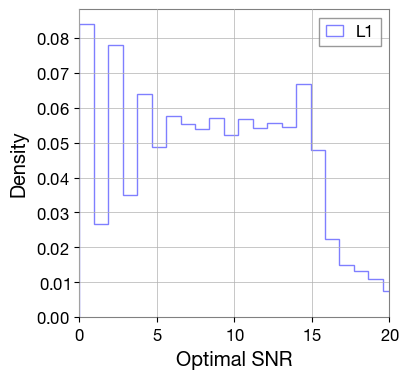

In [61]:
test1 = get_param_from_json("ler_data/L1_IMRPhenomXPHM_1.json")
snr = np.array(test1['optimal_snr_net'])

plt.figure(figsize=[4,4])
plt.hist(snr, bins=100, density=True, alpha=0.5, color='b', histtype='step', label='L1')
plt.xlim([0, 20])
plt.xlabel('Optimal SNR')
plt.ylabel('Density')
plt.legend()
plt.show()

In [60]:
mg = TrainingDataGenerator(
    npool=4,
    verbose=False, 
    ifos=['L1'], 
    output_jsonfile="L1_IMRPhenomXPHM_2.json",
)
mg.gw_parameters_generator(size=1000, batch_size=200000, snr_recalculation=True,trim_to_size=False, verbose=True, data_distribution_range = [6., 8., 10.], replace=False)

total event to collect: 1000



100%|████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 387.96it/s]


Collected number of events: 188


100%|████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 394.30it/s]


Collected number of events: 398


100%|████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 386.45it/s]


Collected number of events: 556


100%|████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 424.94it/s]


Collected number of events: 768


100%|████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 425.98it/s]


Collected number of events: 1008
final size: 1008

json file saved at: ./ler_data/L1_IMRPhenomXPHM_2.json



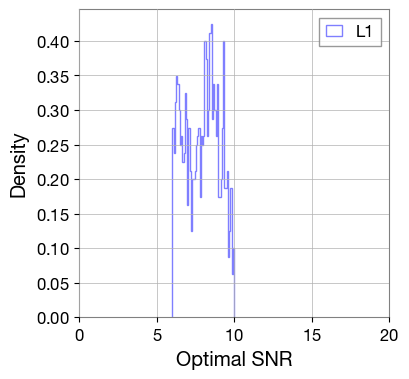

In [63]:
test1 = get_param_from_json("ler_data/L1_IMRPhenomXPHM_2.json")
snr = np.array(test1['optimal_snr_net'])

plt.figure(figsize=[4,4])
plt.hist(snr, bins=50, density=True, alpha=0.5, color='b', histtype='step', label='L1')
plt.xlim([0, 20])
plt.xlabel('Optimal SNR')
plt.ylabel('Density')
plt.legend()
plt.show()

In [64]:
mg = TrainingDataGenerator(
    npool=4,
    verbose=False, 
    ifos=['L1', 'H1', 'V1'], 
    output_jsonfile="L1H1V1_IMRPhenomXPHM.json",
)
mg.gw_parameters_generator(size=1000, batch_size=200000, snr_recalculation=True,trim_to_size=False, verbose=True, data_distribution_range = [0., 2., 4., 6., 8., 10., 12., 14., 16., 100.], replace=True)

total event to collect: 1000



100%|████████████████████████████████████████████████████████████| 522/522 [00:01<00:00, 476.79it/s]


Collected number of events: 405


100%|████████████████████████████████████████████████████████████| 564/564 [00:01<00:00, 472.51it/s]


Collected number of events: 846


100%|████████████████████████████████████████████████████████████| 556/556 [00:01<00:00, 415.76it/s]

Collected number of events: 1242
final size: 1242

json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM.json



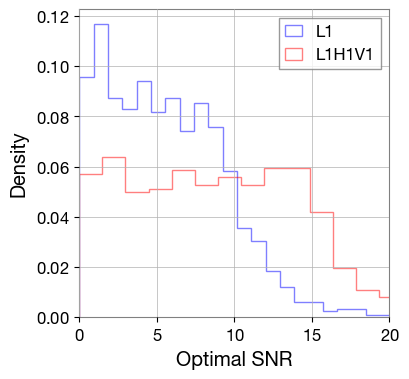

In [66]:
test1 = get_param_from_json("ler_data/L1H1V1_IMRPhenomXPHM.json")
snr = np.array(test1['optimal_snr_net'])
L1 = np.array(test1['L1'])

plt.figure(figsize=[4,4])
plt.hist(L1, bins=50, density=True, alpha=0.5, color='b', histtype='step', label='L1')
plt.hist(snr, bins=50, density=True, alpha=0.5, color='r', histtype='step', label='L1H1V1')
plt.xlim([0, 20])
plt.xlabel('Optimal SNR')
plt.ylabel('Density')
plt.legend()
plt.show()

In [67]:
mg = TrainingDataGenerator(
    npool=4,
    verbose=False, 
    ifos=['L1', 'H1', 'V1'], 
    output_jsonfile="L1H1V1_IMRPhenomXPHM_astro.json",
)
mg.gw_parameters_generator(size=1000, batch_size=1000, trim_to_size=False, verbose=True, data_distribution_range = None, replace=True)

total event to collect: 1000

Collected number of events: 1000
final size: 1000

json file saved at: ./ler_data/L1H1V1_IMRPhenomXPHM_astro.json



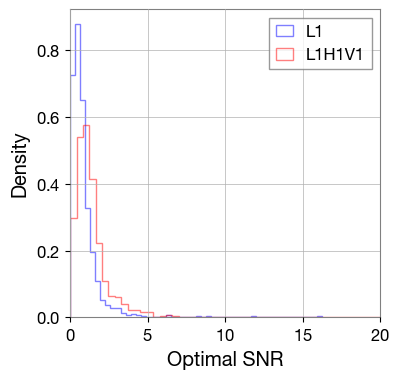

In [68]:
test1 = get_param_from_json("ler_data/L1H1V1_IMRPhenomXPHM_astro.json")
snr = np.array(test1['optimal_snr_net'])
L1 = np.array(test1['L1'])

plt.figure(figsize=[4,4])
plt.hist(L1, bins=50, density=True, alpha=0.5, color='b', histtype='step', label='L1')
plt.hist(snr, bins=50, density=True, alpha=0.5, color='r', histtype='step', label='L1H1V1')
plt.xlim([0, 20])
plt.xlabel('Optimal SNR')
plt.ylabel('Density')
plt.legend()
plt.show()

In [76]:
mg = TrainingDataGenerator()
mg.combine_dicts(
    path_list=[
        "ler_data/L1_IMRPhenomXPHM_1.json",
        "ler_data/L1_IMRPhenomXPHM_2.json",
        "ler_data/L1H1V1_IMRPhenomXPHM.json",
        "ler_data/L1H1V1_IMRPhenomXPHM_astro.json",
    ],
    detector='L1',
    output_jsonfile="L1_IMRPhenomXPHM_combined.json",
)

json file saved at: ./ler_data/L1_IMRPhenomXPHM_combined.json



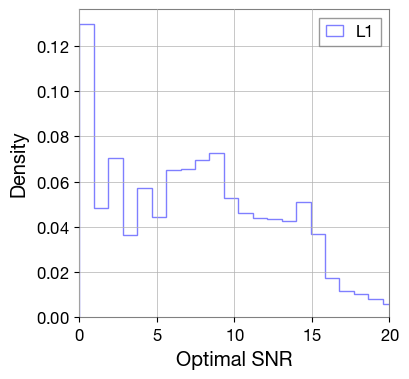

In [78]:
test1 = get_param_from_json("ler_data/L1_IMRPhenomXPHM_combined.json")
snr = np.array(test1['L1'])

plt.figure(figsize=[4,4])
plt.hist(snr, bins=100, density=True, alpha=0.5, color='b', histtype='step', label='L1')
plt.xlim([0, 20])
plt.xlabel('Optimal SNR')
plt.ylabel('Density')
plt.legend()
plt.show()

## ANNModelGenerator

In [159]:
import numpy as np
import os
import pickle
from gwsnr import GWSNR
from ler.utils import append_json, get_param_from_json, load_json, load_pickle, save_pickle, load_hdf5, save_hdf5
from scipy.optimize import curve_fit

In [160]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

In [168]:
class ANNModelGenerator():
    def __init__(self,
        directory="./ler_data",
        npool=4,
        gwsnr_verbose=True,
        snr_th=8.0,
        **kwargs,  # ler and gwsnr arguments
    ):

        self.directory = directory
        self.ann_model = self.ann_model_4layers
        self.ann = None
        self.scaler = None

        self.gwsnr_args = dict(
            npool=npool,
            # gwsnr args
            mtot_min=2.0,
            mtot_max=200,
            ratio_min=0.1,
            ratio_max=1.0,
            mtot_resolution=500,
            ratio_resolution=50,
            sampling_frequency=2048.0,
            waveform_approximant="IMRPhenomXPHM",
            minimum_frequency=20.0,
            snr_type="interpolation",
            psds=None,
            ifos=None,
            interpolator_dir="./interpolator_pickle",
            create_new_interpolator=False,
            gwsnr_verbose=gwsnr_verbose,
            multiprocessing_verbose=True,
            mtot_cut=True,
            snr_th=snr_th,
        )
        self.gwsnr_args.update(kwargs)

        # gwsnr initialization
        # spinless
        self.gwsnr = GWSNR(
            npool=self.gwsnr_args['npool'],
            # gwsnr args
            mtot_min=self.gwsnr_args['mtot_min'],
            mtot_max=self.gwsnr_args['mtot_max'],
            ratio_min=self.gwsnr_args['ratio_min'],
            ratio_max=self.gwsnr_args['ratio_max'],
            mtot_resolution=self.gwsnr_args['mtot_resolution'],
            ratio_resolution=self.gwsnr_args['ratio_resolution'],
            sampling_frequency=self.gwsnr_args['sampling_frequency'],
            waveform_approximant=self.gwsnr_args['waveform_approximant'],
            minimum_frequency=self.gwsnr_args['minimum_frequency'],
            snr_type='interpolation',
            psds=self.gwsnr_args['psds'],
            ifos=self.gwsnr_args['ifos'],
            interpolator_dir=self.gwsnr_args['interpolator_dir'],
            create_new_interpolator=self.gwsnr_args['create_new_interpolator'],
            gwsnr_verbose=self.gwsnr_args['gwsnr_verbose'],
            multiprocessing_verbose=self.gwsnr_args['multiprocessing_verbose'],
            mtot_cut=self.gwsnr_args['mtot_cut'],
            snr_th=self.gwsnr_args['snr_th'],
        )

    def get_input_output_data(self, params=None, randomize=True):

        params = self.get_parameters(params)

        if randomize:
            idx = np.random.choice(len(params['mass_1']), size=len(params['mass_1']), replace=False)
        else:
            idx = np.arange(len(params['mass_1']))

        for key, value in params.items():
            params[key] = np.array(value)[idx]

        X1 = self.get_input_data(params=params)
        # output data
        # get snr for y train
        det_ = self.gwsnr.detector_list[0]
        if 'optimal_snr_net' in params:
            y1 = np.array(params['optimal_snr_net'])
        elif det_ in params:
            y1 = np.array(params[det_])
        else:
            raise ValueError("Output data (snr) not found")

        return X1, y1
        
    def get_input_data(self, params):
        """
        Function to generate input and output data for the neural network

        Parameters:
        idx: index of the parameter points
        params: dictionary of parameter points
            params.keys() = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'psi', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'L1']

        Returns:
        X: input data, [snr_partial_[0], amp0[0], eta, chi_eff, theta_jn]
        y: output data, [L1]
        """

        mass_1 = np.array(params['mass_1'])
        mass_2 = np.array(params['mass_2'])
        luminosity_distance = np.array(params['luminosity_distance'])
        theta_jn = np.array(params['theta_jn'])
        psi = np.array(params['psi'])
        geocent_time = np.array(params['geocent_time'])
        ra = np.array(params['ra'])
        dec = np.array(params['dec'])
        
        detector_tensor = self.gwsnr.detector_tensor_list
        snr_partial_coeff = np.array(self.gwsnr.snr_partialsacaled_list)[0]
        ratio_arr = self.gwsnr.ratio_arr
        mtot_arr = self.gwsnr.mtot_arr
        
        size = len(mass_1)
        len_ = len(detector_tensor)
        if len_ != 1:
            raise ValueError("Only one detector is allowed")

        mtot = mass_1 + mass_2
        ratio = mass_2 / mass_1
        # get array of antenna response
        Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)
        Fp = np.array(Fp[0])
        Fc = np.array(Fc[0])

        Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
        eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
        A1 = Mc ** (5.0 / 6.0)
        ci_2 = np.cos(theta_jn) ** 2
        ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
        
        size = len(mass_1)
        snr_partial_ = np.zeros(size)
        d_eff = np.zeros(size)

        # loop over the detectors
        for i in range(size):
            snr_partial_[i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_partial_coeff, mtot_arr, ratio_arr)
            d_eff[i] =luminosity_distance[i] / np.sqrt(
                    Fp[i]**2 * ci_param[i] + Fc[i]**2 * ci_2[i]
                )
        #amp0
        amp0 =  A1 / d_eff

        # get spin parameters
        a_1 = np.array(params['a_1'])
        a_2 = np.array(params['a_2'])
        tilt_1 = np.array(params['tilt_1'])
        tilt_2 = np.array(params['tilt_2'])

        # effective spin
        chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


        # input data
        X1 = np.vstack([snr_partial_, amp0, eta, chi_eff, theta_jn]).T

        return X1

    def standard_scaling_initialization(self, X_train):

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        self.scaler = sc

        return X_train, sc

    def ann_model_4layers(self, 
        num_nodes_list,
        activation_fn_list,
        optimizer,
        loss,
        metrics,
    ):
        ann = tf.keras.models.Sequential()

        for i in range(1, len(num_nodes_list)):
            ann.add(tf.keras.layers.Dense(units=num_nodes_list[i], activation=activation_fn_list[i]))

        # compile the ANN
        ann.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return ann

    def get_parameters(self, gw_param_dict):

        # get the parameters
        if isinstance(gw_param_dict, str):
            path_ = f"{self.directory}/{gw_param_dict}"
            gw_param_dict = get_param_from_json(path_)
        elif isinstance(gw_param_dict, dict):
            pass
        else:
            raise ValueError("gw_param_dict must be a dictionary or a json file")

        return gw_param_dict

    def get_scaled_data(self, gw_param_dict, randomize=True, test_size=0.1, random_state=42):

        gw_param_dict = self.get_parameters(gw_param_dict)

        # input and output data
        X, y = self.get_input_output_data(params=gw_param_dict, randomize=randomize)

        # scaling
        X_test = self.scaler.transform(X_test)

        return X_test, y_test

    def ann_model_training(self,
        gw_param_dict,
        randomize=True,
        test_size=0.1,
        random_state=42,
        num_nodes_list = [5, 32, 32, 1],
        activation_fn_list = ['relu', 'relu', 'sigmoid', 'linear'],
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy'],
        batch_size=32,
        epochs=100,
        error_adjustment_snr_range=[4,10],
        ann_file_name = 'ann_model.h5',
        scaler_file_name = 'scaler.pkl',
        error_adjustment_file_name='error_adjustment.json',
        ann_path_dict_file_name='ann_path_dict.json',
    ):
        snr_threshold = self.gwsnr_args['snr_th']   # snr threshold

        # input and output data
        X, y = self.get_input_output_data(params=gw_param_dict, randomize=randomize)

        # split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # scaling
        X_scaled, scaler = self.standard_scaling_initialization(X_train)
        self.X_test = scaler.transform(X_test)
        self.y_test = y_test
        # save the scaler
        pickle.dump(scaler, open(f'{self.directory}/{scaler_file_name}', 'wb'))

        # initialize the ANN
        ann = self.ann_model(num_nodes_list, activation_fn_list, optimizer, loss, metrics)

        # fit the ANN to the training set
        ann.fit(X_scaled, y_train, batch_size=batch_size, epochs=epochs)
        # for testing
        self.ann = ann
        # save the model
        ann.save(f'{self.directory}/{ann_file_name}')

        # error adjustment
        y_pred = np.array(ann.predict(self.X_test)).flatten()
        self.error_adjustment = self.helper_error_adjustment(y_pred, y_test, snr_range=error_adjustment_snr_range)
        append_json(f'{self.directory}/{error_adjustment_file_name}', self.error_adjustment, replace=True)

        # print the results
        print(f"scaler saved at: {self.directory}/{scaler_file_name}")
        print(f"model saved at: {self.directory}/{ann_file_name}")
        print(f"error adjustment saved at: {self.directory}/{error_adjustment_file_name}")

        # save the path of the model, scaler, and error adjustment
        self.save_ann_path_dict(
            ann_file_name=ann_file_name, 
            scaler_file_name=scaler_file_name, 
            error_adjustment_file_name=error_adjustment_file_name,
            ann_path_dict_file_name=ann_path_dict_file_name,
        )

    def pdet_error(self, gw_param_dict=None, randomize=True):

        snr_threshold = self.gwsnr_args['snr_th']   # snr threshold

        if gw_param_dict is not None:
            gw_param_dict = self.get_parameters(gw_param_dict)
            # input and output data
            X_test, y_test = self.get_input_output_data(params=gw_param_dict, randomize=randomize)
            X_test = self.scaler.transform(X_test)
        else:
            X_test = self.X_test
            y_test = self.y_test

        # calculate the error
        y_pred = self.ann.predict(X_test).flatten()
        len1 = len(y_pred)
        len2 = np.sum((y_pred>snr_threshold) != (y_test>snr_threshold))
        error = len2/len1*100
        print(f"Error: {error:.2f}%")

        return error, y_pred, y_test

    def save_ann_path_dict(self, 
        ann_file_name='ann_model.h5', 
        scaler_file_name='scaler.pkl', error_adjustment_file_name='error_adjustment.json',
        ann_path_dict_file_name='ann_path_dict.json',
    ):

        if not os.path.exists(f'{self.directory}/{ann_path_dict_file_name}'):
            ann_path_dict = {}
        else:
            ann_path_dict = load_json(f'{self.directory}/{ann_path_dict_file_name}')

        # check if the files exist
        if not os.path.exists(f'{self.directory}/{ann_file_name}'):
            raise ValueError("Model file does not exist")
        if not os.path.exists(f'{self.directory}/{scaler_file_name}'):
            raise ValueError("Scaler file does not exist")
        if not os.path.exists(f'{self.directory}/{error_adjustment_file_name}'):
            raise ValueError("Error adjustment file does not exist")
            
        ann_path_dict_ = {
            "L1": {
                "model_path": f'{self.directory}/{ann_file_name}',
                "scaler_path": f'{self.directory}/{scaler_file_name}',
                "error_adjustment_path": f'{self.directory}/{error_adjustment_file_name}',
                "sampling_frequency": self.gwsnr_args['sampling_frequency'],
                "minimum_frequency": self.gwsnr_args['minimum_frequency'],
                "waveform_approximant": self.gwsnr_args['waveform_approximant'], 
                "snr_th": self.gwsnr_args['snr_th'],},
        }

        ann_path_dict.update(ann_path_dict_)
        append_json(f'{self.directory}/{ann_path_dict_file_name}', ann_path_dict, replace=True)
        print(f"ann path dict saved at: {self.directory}/{ann_path_dict_file_name}")

        return ann_path_dict

    def pdet_confusion_matrix(self, gw_param_dict=None, randomize=True, snr_threshold=8.0):

        if gw_param_dict is not None:
            gw_param_dict = self.get_parameters(gw_param_dict)
            # input and output data
            X_test, y_test = self.get_input_output_data(params=gw_param_dict, randomize=randomize)
            X_test = self.scaler.transform(X_test)
        else:
            X_test = self.X_test
            y_test = self.y_test

        # calculate the error
        y_pred = self.ann.predict(X_test).flatten()
        y_pred = (y_pred>snr_threshold)
        y_test = (y_test>snr_threshold)

        # # Making the Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        accuracy = accuracy_score(y_test, y_pred)*100
        print(f"Accuracy: {accuracy:.3f}%")

        return cm, accuracy, y_pred, y_test

    def load_model_scaler_error(self, 
        ann_file_name='ann_model.h5', 
        scaler_file_name='scaler.pkl',
        error_adjustment_file_name=False,
    ):
        # load the model
        self.ann = load_model(f'{self.directory}/{ann_file_name}')
        self.scaler = pickle.load(open(f'{self.directory}/{scaler_file_name}', 'rb'))
        if error_adjustment_file_name:
            self.error_adjustment = get_param_from_json(f'{self.directory}/{error_adjustment_file_name}')

            return self.ann, self.scaler, self.error_adjustment
        else:
            return self.ann, self.scaler

    def helper_error_adjustment(self, y_pred, y_test, snr_range=[4,10]):

        def linear_fit_fn(x, a, b):
            return a*x + b

        idx = (y_pred>snr_range[0]) & (y_pred<snr_range[1])
        idx &= (y_test != 0)
        popt, pcov = curve_fit(linear_fit_fn, y_pred[idx], y_pred[idx]-y_test[idx])

        adjustment_dict = {'slope': popt[0], 'intercept': popt[1]}

        return adjustment_dict

    def snr_error_adjustment(self, gw_param_dict=None, randomize=True, snr_threshold=8.0, snr_range=[4,10], error_adjustment_file_name='error_adjustment.json'):

        _, y_pred_, y_test_ = self.pdet_error(gw_param_dict=gw_param_dict, randomize=True, snr_threshold=snr_threshold)

        self.error_adjustment = self.helper_error_adjustment(y_pred_, y_test_, snr_range=snr_range)

        print(f"slope: {self.error_adjustment['slope']:.4f}, intercept: {self.error_adjustment['intercept']:.4f}")

        # save json file
        append_json(f'{self.directory}/{error_adjustment_file_name}', self.error_adjustment, replace=True)
        print(f"error adjustment saved at: {self.directory}/{error_adjustment_file_name}")

        return self.error_adjustment

    def predict_snr(self, gw_param_dict):

        params = self.get_parameters(gw_param_dict)

        # input and output data
        X_test, y_test = self.get_input_output_data(params=params)
        X_test = self.scaler.transform(X_test)

        # calculate the error
        y_pred = self.ann.predict(X_test).flatten()

        return y_pred, y_test

    def predict_pdet(self, gw_param_dict, snr_threshold=8.0):

        y_pred, y_test = self.predict_snr(gw_param_dict)
        y_pred = (y_pred>snr_threshold)
        y_test = (y_test>snr_threshold)

        return y_pred, y_test

In [169]:
ann = ANNModelGenerator(ifos=['L1'], gwsnr_verbose=False)

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle


In [173]:
ann.predict_pdet('L1_IMRPhenomXPHM_combined.json', snr_threshold=8.0)

417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


(array([False,  True, False, ...,  True,  True, False]),
 array([False,  True,  True, ...,  True,  True, False]))

In [126]:
ann.load_model_scaler_error(ann_file_name='ann_model.h5', scaler_file_name='scaler.pkl');

In [175]:
ann.pdet_error(gw_param_dict='L1_IMRPhenomXPHM_combined.json', randomize=True);

417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
Error: 3.91%


In [176]:
ann.pdet_confusion_matrix(gw_param_dict='L1_IMRPhenomXPHM_combined.json', randomize=True, snr_threshold=8.0);

417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
[[6644  229]
 [ 292 6174]]
Accuracy: 96.094%


In [127]:
ann.snr_error_adjustment(gw_param_dict='L1_IMRPhenomXPHM_combined.json', randomize=True, snr_threshold=8.0, snr_range=[4,10], error_adjustment_file_name='error_adjustment.json');

417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Error: 3.92%
number of data points: 13339
slope: -0.0076, intercept: 0.0013
error adjustment saved at: ./ler_data/error_adjustment.json


In [170]:
ann.ann_model_training(epochs=100, gw_param_dict='L1_IMRPhenomXPHM_combined.json')

Epoch 1/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.0000e+00 - loss: 71.5183
Epoch 2/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 1.3396e-04 - loss: 20.4197
Epoch 3/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 9.5095e-04 - loss: 14.9034
Epoch 4/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - accuracy: 6.5603e-04 - loss: 11.1339
Epoch 5/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 4.5039e-04 - loss: 8.0265
Epoch 6/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 4.2797e-04 - loss: 7.3401
Epoch 7/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 5.9168e-04 - loss: 5.6126
Epoch 8/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - accuracy: 6.7254e-04 - loss: 6.6672
Epoch 9/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 2.7297e-04 - loss: 4.3140
Epoch 10/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 5.9710e-04 - loss: 4.3143
Epoch 11/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accurac

In [171]:
np.array(ann.ann(ann.X_test)).flatten()

array([13.21199  ,  9.393047 ,  5.794366 , ...,  2.1224108,
       11.827897 ,  4.223282 ], dtype=float32)

In [172]:
ann.y_test

array([13.59773649,  9.90530982,  5.85352611, ...,  2.12768409,
       12.5382342 ,  4.06693041])

In [3]:
from gwsnr import GWSNR
import numpy as np

gwsnr = GWSNR(
    snr_type='ann',
    waveform_approximant="IMRPhenomXPHM",
    ifos=['L1'],
    ann_path_dict='./ler_data/ann_path_dict.json',
)

Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
ANN model for L1 is loaded from ./ler_data/ann_model.h5.
ANN scaler for L1 is loaded from ./ler_data/scaler.pkl.
ANN error_adjustment for L1 is loaded from ./ler_data/error_adjustment.json.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [6]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_12 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_jl = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# pdet calculation with ANN
pdet_ann = gwsnr.snr(gw_param_dict=param_dict)
print(f'Probability of detection (with ANN): \n{pdet_ann}')

Probability of detection (with ANN): 
{'L1': array([ 7.55985785,  6.10763454, 11.9991436 ,  0.        ]), 'optimal_snr_net': array([ 7.55985785,  6.10763454, 11.9991436 ,  0.        ])}


In [5]:
gwsnr.compute_bilby_snr(gw_param_dict=param_dict)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.70s/it]


{'L1': array([ 8.30585543,  6.87001242, 13.2429687 ,  0.        ]),
 'optimal_snr_net': array([ 8.30585543,  6.87001242, 13.2429687 ,  0.        ])}

In [7]:
gwsnr.snr_with_interpolation(gw_param_dict=param_dict)

TypeError: GWSNR.snr_with_interpolation() got an unexpected keyword argument 'gw_param_dict'